# Paststat register - Exercise 2
In this exercise we will learn about Unitary Patent (UP) data in PATSTAT register. We will build a query that shows the patents for which the request for unitary effect has been rejected, and a query that retrieves the proprietor with the most Unitary patents with effect registered. 

In [6]:
# Importing the patstat client
from epo.tipdata.patstat import PatstatClient

# Initialize the PATSTAT client
patstat = PatstatClient()

# Access ORM
db = patstat.orm()
# Importing tables as models
from epo.tipdata.patstat.database.models import REG701_APPLN, REG741_APPLN_STATUS, REG707_PARTIES, REG101_APPLN


## The REG701_APPLN table
If you look at the logical model of PATSTAT Register in the [official documentation](https://link.epo.org/web/searching-for-patents/business/patstat/data-catalog-patsat-ep-register-spring-en.pdf) you can see that Unitary Patent data is based on table `REG701_APPLN`. This table contains application IDs for which unitary effect has been requested. This table only has two fields. 

 - **ID:** This is the primary key for the table, used to identify the application and is also a foreign key referencing the `REG101_APPLN` table.
 - **STATUS:** The current status of the unitary patent, which is a foreign key referencing the `REG741_APPLN_STATUS` table.

Let's take a look at the data in the `REG701_APPLN` table.

In [2]:
q = db.query(
    REG701_APPLN.id,
    REG701_APPLN.status
)
res = patstat.df(q)
res

,id,status
0,20163839,4
1,6748170,4
2,18180076,4
3,20191429,4
4,18158904,4
...,...,...
20245,18879480,9
20246,17160607,9
20247,19725218,9
20248,17180658,9


## Understanding UP stata
You can see that in table 701 the `status` field is a number, which does not tell us much. In order to find out the definition of each status, we need to use `REG741_APPLN_STATUS`, which contains the description of each of the status numbers. 

In [26]:
q = db.query(
    REG741_APPLN_STATUS.status_text,
    REG741_APPLN_STATUS.status
)

res = patstat.df(q)
res

,status_text,status
0,Unitary effect registered,9
1,Request for unitary effect filed,6
2,Request for unitary effect withdrawn,4
3,Request for unitary effect rejected,5


## Joining the 701 and 741 tables
When analyzing UP data, you probably want to have the description of the events in your query, instead of a number that is not really descriptive. Let's perform a simple join of the two tables. 

In [4]:
q = db.query(
    REG701_APPLN.id,
    REG741_APPLN_STATUS.status_text
).join(
   REG741_APPLN_STATUS, REG701_APPLN.status == REG741_APPLN_STATUS.status
)
res = patstat.df(q)
res

,id,status_text
0,18759301,Unitary effect registered
1,21177871,Unitary effect registered
2,19155020,Unitary effect registered
3,19164056,Unitary effect registered
4,18844476,Unitary effect registered
...,...,...
20245,18813702,Request for unitary effect rejected
20246,19162343,Request for unitary effect rejected
20247,8016936,Request for unitary effect rejected
20248,19020506,Request for unitary effect rejected


## Aggregating the applications per status
We can now perform a quick analysis: of all the applications for which unitary effect has been requested, what is the distribution of the different stata.

We need to use SQLAlchemy's `func.count()` to count the number of id entries in the `REG701_APPLN` table. The result is labeled as applications for clarity. We then need to group the query results by the status_text field from the REG741_APPLN_STATUS table. Grouping by status_text ensures that the count of applications is aggregated for each unique status.

In [5]:
# we need the func module to count the applications
from sqlalchemy import func

q = db.query(
    func.count(REG701_APPLN.id).label('applications'), # counting the applications and labeling the result as applications
    REG741_APPLN_STATUS.status_text.label('status')    # labeling the status text as status
).join(
   REG741_APPLN_STATUS, REG701_APPLN.status == REG741_APPLN_STATUS.status
).group_by(
    REG741_APPLN_STATUS.status_text # grouping by status
)
res = patstat.df(q)
res

,applications,status
0,26,Request for unitary effect withdrawn
1,12,Request for unitary effect rejected
2,443,Request for unitary effect filed
3,19769,Unitary effect registered


## Finding the rejected unitary patents
You can see in the results that the vast majority of requests are registered, but there is a small number of requests that are rejected. Let's get the application number for those patents and a link to the register for each one.

We need to join tables `REG701_APPLN` and `REG101_APPLN`, since table 101 contains the application numbers.

In [ ]:
q = db.query(
    REG701_APPLN.id,
    REG101_APPLN.appln_nr
).join(
    # Join REG701_APPLN with REG101_APPLN on matching IDs
    REG101_APPLN, REG701_APPLN.id == REG101_APPLN.id
).filter(
    # Filter to include only applications with status 5, for rejected
    REG701_APPLN.status == 5
)
res = patstat.df(q)
res

### Getting the link to the Register
We can easily generate links to the register for each of the applications, to find out what was the reason for rejection. The register page for each application contains the application number encoded in the url. We simply need to iterate through the dataframe `res` and for each application number we can compose the url inserting the application number into it. 

In [12]:
# Loop through each row in the resulting DataFrame
for index, row in res.iterrows():
    # Extract the application number from the current row
    appln_nr = row['appln_nr']
    
    # Print the URL to the register page for the current application
    print(f"https://register.epo.org/application?number=EP{appln_nr}")


https://register.epo.org/application?number=EP17780779
https://register.epo.org/application?number=EP18191168
https://register.epo.org/application?number=EP10182858
https://register.epo.org/application?number=EP19189650
https://register.epo.org/application?number=EP17165970
https://register.epo.org/application?number=EP18209801
https://register.epo.org/application?number=EP18174013
https://register.epo.org/application?number=EP18190147
https://register.epo.org/application?number=EP19162343
https://register.epo.org/application?number=EP08016936
https://register.epo.org/application?number=EP19020506
https://register.epo.org/application?number=EP18813702


## The proprietor with most Unitary Patents
For the second part of this exercise we are going create a ranking of the proprietors of Unitary patents. We need to join the `REG701_APPLN` and the `REG707_PARTIES`, since table 707 contains the information about the parties associated with a unitary patent. Table `REG707_PARTIES` is very similar to  the table `REG107_PARTIES` that we saw on exercise 1. 

In [13]:
q = db.query(
    # Select the count of 'REG701_APPLN.id' and label it as "Unitary Patents Registered"
    func.count(REG701_APPLN.id).label("Unitary Patents Registered"),
    # Select 'REG707_PARTIES.name' and label it as 'Proprietor'
    REG707_PARTIES.name.label('Proprietor')
).join(
    # Perform a join between 'REG707_PARTIES' and 'REG701_APPLN' on the matching 'id' field
    REG707_PARTIES, REG701_APPLN.id == REG707_PARTIES.id
).filter(
    # Apply filters where 'REG707_PARTIES.type' is 'A' for proprietor
    REG707_PARTIES.type == 'A',
    # and 'REG701_APPLN.status' is 9 for patents with unitary effect registered
    REG701_APPLN.status == 9
).group_by(
    # Group the results by 'REG707_PARTIES.name'
    REG707_PARTIES.name
).order_by(
    # Order the results by the count of 'REG701_APPLN.id' in descending order
    func.count(REG701_APPLN.id).desc()
)

# Execute the query and convert the result to a DataFrame
res = patstat.df(q)

# Display the result
res


,Unitary Patents Registered,Proprietor
0,233,"Samsung Electronics Co., Ltd."
1,149,Telefonaktiebolaget LM Ericsson (publ)
2,136,Ethicon LLC
3,133,Siemens Aktiengesellschaft
4,129,QUALCOMM Incorporated
...,...,...
12299,1,Airinspace
12300,1,Innate S.r.l.
12301,1,"MacRae, Allan J."
12302,1,Pyromeral Systems


In [32]:
q = db.query(
    func.count(REG701_APPLN.id).label("Unitary Patents Registered"),
    REG707_PARTIES.name.label('Proprietor')
).join(
    REG707_PARTIES, REG701_APPLN.id == REG707_PARTIES.id
).filter(
    REG707_PARTIES.type == 'A',
    REG701_APPLN.status == 9
).group_by(
    REG707_PARTIES.name
).order_by(
    func.count(REG701_APPLN.id).desc()
)

res = patstat.df(q)
res

,Unitary Patents Registered,Proprietor
0,233,"Samsung Electronics Co., Ltd."
1,149,Telefonaktiebolaget LM Ericsson (publ)
2,136,Ethicon LLC
3,133,Siemens Aktiengesellschaft
4,129,QUALCOMM Incorporated
...,...,...
12299,1,Airinspace
12300,1,Innate S.r.l.
12301,1,"MacRae, Allan J."
12302,1,Pyromeral Systems


## One more thing...
Tip comes loaded with the most common data processing libraries. One of them is Mathplotlib, a a comprehensive library for creating static, animated, and interactive visualizations in Python. It is widely used for plotting graphs and charts, offering a variety of plotting functions to create line plots, scatter plots, bar charts, histograms, and more.

Let's use Mathplotlib to create a visualization of the top 10 UP proprietors. 

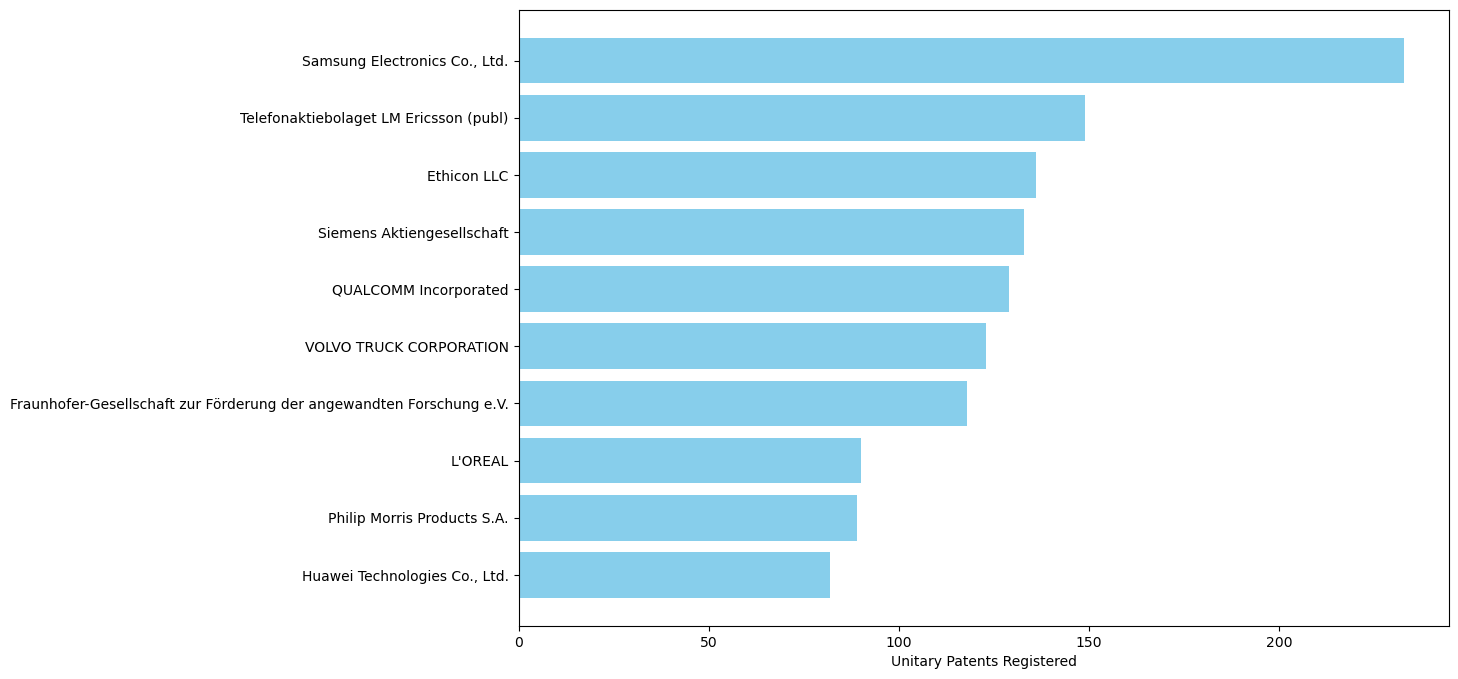

In [25]:
# Creating the bar graph with horizontal bars
plt.figure(figsize=(12, 8))  # Set the figure size to 12 inches by 8 inches

# Create a horizontal bar plot with 'Proprietor' on the y-axis and 'Unitary Patents Registered' on the x-axis
plt.barh(top_10['Proprietor'], top_10['Unitary Patents Registered'], color='skyblue')

plt.xlabel('Unitary Patents Registered')  # Label the x-axis as 'Unitary Patents Registered'

plt.gca().invert_yaxis()  # To display the highest value at the top
plt.show()  # Display the plot
